In [1]:
filename = "files/master_statistics.log"

In [2]:
with open(filename) as inf:
    log = inf.readlines()

In [3]:
len(log)

76374

In [4]:
log[:5]

['2019-11-30 14:42:41,071,STATS,INFO,PROGRAM,STARTED\n',
 '2019-11-30 14:42:41,086,STATS,INFO,CONNECTED,SERIAL\n',
 '2019-11-30 14:42:42,534,STATS,DEBUG,INPUT,C\n',
 '2019-11-30 14:42:42,836,STATS,DEBUG,INPUT,U\n',
 '2019-11-30 14:42:42,837,STATS,INFO,HANDSET_UP\n']

In [5]:
headers = ['date', 'dialed', 'log', 'level', 'event', 'extra']

In [6]:
import pandas as pd

In [7]:
def parse_data(tokens):
    data = {'date': tokens[0], 'dialed': tokens[1]}
    if tokens[-2] == "INFO":
        data['event'] = tokens[-1]
        return data
    if tokens[-2] == "SANTA":
        if tokens[-1] == 'Printing receipt from Santa':
            data['event'] = "PRINT"
            return data
        elif tokens[-1].startswith("Not printing receipt from Santa"):
            data['event'] = "TOO_QUICK"
            return data
        else:
            data['event'] = "TIME"
            data['value'] = tokens[-1].split("for ")[1].split()[0]
    if len(tokens) in {5, 6}:
        data['event'] = f"{tokens[-2]}_{tokens[-1]}"
        return data
    elif tokens[4] == "SANTA":
        if tokens[5] == "TIME":
            data['event'] = "SANTA_TIME"
            data['value'] = float(tokens[6])
            return data
    print(list(enumerate(tokens)))
    raise ValueError("unknown tokens")

In [8]:
data = []
for line in log:
    tokens = line.strip().split(",")
    data.append(parse_data(tokens))

In [9]:
tokens

['2020-01-02 08:17:21', '805', 'STATS', 'DEBUG', 'INPUT', 'C']

In [10]:
stats = pd.DataFrame(data)

In [11]:
stats['date'] = pd.to_datetime(stats['date'])
stats.set_index('date', inplace=True)
stats.head()

dialed             event  value
date                                               
2019-11-30 14:42:41    071   PROGRAM_STARTED    NaN
2019-11-30 14:42:41    086  CONNECTED_SERIAL    NaN
2019-11-30 14:42:42    534           INPUT_C    NaN
2019-11-30 14:42:42    836           INPUT_U    NaN
2019-11-30 14:42:42    837        HANDSET_UP    NaN

In [12]:
per_event = stats.groupby('event').count().sort_values('dialed', ascending=False)[['dialed']]
per_event

dialed
event                                                     
INPUT_U                                              10269
HANDSET_UP                                           10269
INPUT_D                                              10260
HANDSET_DOWN                                         10260
RUN_72682                                            10079
TOO_QUICK                                             5832
PLAY_Playing message from file data/1128_Christ...    5043
PLAY_Playing message from file data/1121_Christ...    5036
SANTA_TIME                                            4247
PRINT                                                 4247
INPUT_2                                                218
INPUT_7                                                149
INPUT_6                                                118
INPUT_8                                                104
INPUT_4                                                 30
INPUT_3                                                 28
PROGRAM_STARTED                                         23
CONNECTED_SERIAL                                        23
INPUT_C                                                 23
INPUT_0                                                 22
INPUT_1                                                 20
INPUT_5                                                 13
INPUT_*                                                  8
Performing test routine                                  7
Playing test sound                                       7
Printing test receipt                                    7
RUN_1337                                                 7
INPUT_#                                                  7
Tests sent_ I cannot confirm or deny that worked         7
RUN_72672                                                6
INPUT_9                                                  5

In [13]:
import seaborn as sns

In [14]:
per_event.loc[per_event.index.isin(['PRINT', "TOO_QUICK"])].plot(kind='bar')

In [15]:
per_event.loc['PRINT'], per_event.loc['TOO_QUICK'], per_event.loc['PRINT'] / (per_event.loc['PRINT'] + per_event.loc['TOO_QUICK'])

(dialed    4247
 Name: PRINT, dtype: int64, dialed    5832
 Name: TOO_QUICK, dtype: int64, dialed    0.421371
 dtype: float64)

In [17]:
timemask = stats['event'] == "SANTA_TIME"
# printed = stats[''] == "SANTA_TIME"

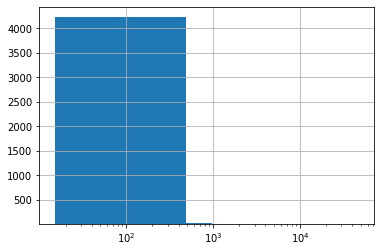

In [18]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
stats.loc[timemask, 'value'].hist(ax=ax, bins=100, bottom=0.1)
ax.set_xscale('log')

In [19]:
times = stats.loc[timemask, 'value']
times.describe()

count     4247.000000
mean        73.104291
std        734.142990
min         15.002918
25%         33.846347
50%         54.497062
75%         78.401562
max      47759.704436
Name: value, dtype: float64

In [20]:
times_scrubbed = times.loc[(times < 200)]

In [21]:
times_scrubbed.describe()

count    4197.000000
mean       57.419646
std        29.248411
min        15.002918
25%        33.529452
50%        54.119915
75%        77.906864
max       195.735908
Name: value, dtype: float64

Notes: Times greater than 200 removed. Must be at least 15 seconds to register


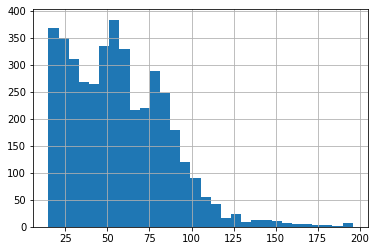

In [22]:
times_scrubbed.hist(bins=30)
print("Notes: Times greater than 200 removed. Must be at least 15 seconds to register")

In [23]:
handset_up = stats[stats['event'] == 'HANDSET_UP']
handset_up.resample("D")['dialed'].count()

date
2019-11-30      13
2019-12-01       0
2019-12-02      95
2019-12-03     124
2019-12-04     160
2019-12-05     166
2019-12-06     262
2019-12-07     381
2019-12-08     315
2019-12-09     122
2019-12-10     237
2019-12-11     301
2019-12-12     329
2019-12-13     397
2019-12-14     666
2019-12-15     757
2019-12-16     565
2019-12-17     416
2019-12-18     343
2019-12-19     409
2019-12-20     336
2019-12-21     814
2019-12-22       0
2019-12-23    1044
2019-12-24     987
2019-12-25     236
2019-12-26     484
2019-12-27     310
Freq: D, Name: dialed, dtype: int64

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
handset_up.resample("D")['dialed'].count().plot(ax=ax, kind='bar')

In [25]:
handset_up.groupby(handset_up.index.day_name())['dialed'].count().sort_values()

date
Wednesday    1040
Sunday       1072
Friday       1305
Thursday     1388
Tuesday      1764
Monday       1826
Saturday     1874
Name: dialed, dtype: int64

In [26]:
from calendar import day_name

In [27]:
day_name

In [28]:
H = handset_up.groupby(handset_up.index.day_name()).count()

In [29]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
H['Date'] = pd.Categorical(H.index.values, categories=cats, ordered=True)

In [30]:
H.sort_values("Date", inplace=True)

In [31]:
H['dialed'].plot(kind='bar')

In [32]:
per_hour = handset_up.groupby(handset_up.index.hour)['dialed'].count().sort_index()

In [33]:
per_hour.plot(kind='bar')

In [34]:
fig, ax = plt.subplots(figsize=(24, 8))
handset_up.resample("H")['dialed'].count().plot(ax=ax)